## Table of Contents

#### Set-Up
- [Splitting the data](#split)
- [Adjusting some features](#adjusting)
- [Clustering](#clustering)



- [Model Application](#application)
- [Normalized Feature Rankings in each Generation](#rankings)
- [Applying the Model to each Generation](#apply_model)

**Final Modeling Notebook Plan:**  I'm going to test all of my best models from all the previous modeling notebooks on the test set, instead of just my one best model.

Normally you shouldn't test multiple models on the test set, since then there is a danger of tuning your performance to the test set, but I think there are ways to mitigate that problem.

I'm not going to choose the best model based on minor improvements or close comparisons on the test set; I'll value training and validation scores more in terms of performance. But if there is a massive performance change on the test on only some of the models but not others, then statistically that is extremely unlikely to be due to the peculiarities of the test set. Rather, it's a sign of massive overfitting, so using the test set to look for massive changes in performance in different models is a legitimate tactic in my opinion (small differences between the models will not be considered relevant).

Finally, since our best models are random forest models which already have very high accuracy on 7 classes, we aren't going to bother with any of the 4 class models. We will only be testing the best 7 class models of each type.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import json
import pandas_profiling
import requests
import h2o
from subprocess import call
from IPython.display import Image
from graphviz import render
from bs4 import BeautifulSoup
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import precision_recall_fscore_support, log_loss, r2_score, mean_squared_error, f1_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from h2o.estimators import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 day 4 hours 12 mins
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,2 months and 24 days
H2O_cluster_name:,H2O_from_python_Owner_39uzrv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.955 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [2]:
pokemon_abilities_df = pd.read_csv('./data/pokemon_abilities_df.csv', index_col="name")
pokemon_learnsets_df = pd.read_csv('./data/pokemon_learnsets_df.csv', index_col='name')
pokemon_data = pd.read_csv('./data/pokemon_data.csv', index_col="name")

In [3]:
pokemon_data

,hp,atk,def,spa,spd,spe,weight,height,formats,generation,...,Ability Cutoff 2,Ability Cutoff 3,Ability Cutoff 4,Ability Cutoff 5,Ability Cutoff 6,Best Ability,Best Ability <100,Unique Powerful Ability,oldformats,oldformat codes
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,45,49,49,65,65,45,6.9,0.7,ZU,RB,...,1.0,0.0,0.0,0.0,0.0,63.636364,63.636364,0,ZU,0
Ivysaur,60,62,63,80,80,60,13.0,1.0,ZU,RB,...,1.0,0.0,0.0,0.0,0.0,63.636364,63.636364,0,ZU,0
Venusaur,80,82,83,100,100,80,100.0,2.0,OU,RB,...,1.0,0.0,0.0,0.0,0.0,63.636364,63.636364,0,UU,4
Charmander,39,52,43,60,50,65,8.5,0.6,ZU,RB,...,1.0,0.0,0.0,0.0,0.0,50.000000,50.000000,0,ZU,0
Charmeleon,58,64,58,80,65,80,19.0,1.1,ZU,RB,...,1.0,0.0,0.0,0.0,0.0,50.000000,50.000000,0,ZU,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,100,145,130,65,110,30,800.0,2.2,NU,SS,...,1.0,1.0,1.0,0.0,0.0,75.000000,75.000000,0,NU,2
Spectrier,100,65,60,145,80,130,44.5,2.0,Uber,SS,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,1,Uber,6
Calyrex,100,80,80,80,80,80,7.7,1.1,PU,SS,...,0.0,0.0,0.0,0.0,0.0,18.181818,18.181818,0,ZU,0


<a id="split"></a>
### Splitting the Data

In [4]:
pokemon_data.columns

Index(['hp', 'atk', 'def', 'spa', 'spd', 'spe', 'weight', 'height', 'formats',
       'generation', 'format codes', 'Weaknesses', 'Strong Weaknesses',
       'Resists', 'Strong Resists', 'Immune', 'STAB', 'Resistance Index',
       'Entry Hazards', 'Hazard Removal', 'Removal Deterrent', 'Cleric',
       'Pivot', 'Item Removal', 'Setup', 'Priority', 'HP Drain', 'HP Recovery',
       'Weather Set', 'Weather Gimmick', 'Physical Cutoff 1',
       'Physical Cutoff 2', 'Physical Cutoff 3', 'Physical Cutoff 4',
       'Physical Cutoff 5', 'Physical Cutoff 6', 'Physical Coverage 1',
       'Physical Coverage 2', 'Physical Coverage 3', 'Physical Coverage 4',
       'Special Cutoff 1', 'Special Cutoff 2', 'Special Cutoff 3',
       'Special Cutoff 4', 'Special Cutoff 5', 'Special Cutoff 6',
       'Special Cutoff 7', 'Special Coverage 1', 'Special Coverage 2',
       'Special Coverage 3', 'Special Coverage 4', 'Special Coverage 5',
       'Special Coverage 6', 'Special Coverage 7', 'Special Cove

In [5]:
X = pokemon_data.drop(columns=['weight', 'height', 'Weaknesses', 'Strong Weaknesses', 'Resists',
                                'Strong Resists', 'Immune', 'STAB', 'Physical Cutoff 1', 'Physical Cutoff 2',
                                'Physical Cutoff 4', 'Physical Cutoff 5', 'Physical Cutoff 6',
                                'Physical Coverage 1', 'Physical Coverage 2', 'Physical Coverage 4',
                                'Special Cutoff 1', 'Special Cutoff 2', 'Special Cutoff 4',
                                'Special Cutoff 5', 'Special Cutoff 6', 'Special Cutoff 7',
                                'Special Coverage 1', 'Special Coverage 2', 'Special Coverage 3',
                                'Special Coverage 4', 'Special Coverage 6', 'Special Coverage 7',
                                'Special Coverage 8', 'Special Coverage 9', 'Special Coverage 10',
                                'Ability Cutoff 1', 'Ability Cutoff 2', 'Ability Cutoff 4', 'Ability Cutoff 5',
                                'Ability Cutoff 6', 'Best Ability <100', 'formats', 'generation',
                                'format codes', 'oldformats', 'oldformat codes'])

y_df = pd.DataFrame(pokemon_data[['formats', 'format codes']], index=pokemon_data.index, columns=['formats', 'format codes', 'oldformats', 'oldformat codes'])
y_df['formats4'] = y_df['formats'].replace({'ZU':'Not c', 'PU': 'Low c', 'NU': 'Mid c', 'RU': 'Mid c', 'UU': 'Mid c', 'OU': 'High c', 'Uber': 'High c'})
y_df['format codes4'] = y_df['format codes'].replace({3:2, 4: 2, 5:3, 6:3})
y_df['formats4alt'] = y_df['formats'].replace({'ZU':'Not c', 'PU': 'Low c', 'NU': 'Mid c', 'RU': 'Mid c', 'UU': 'Mid c', 'OU': 'Mid c', 'Uber': 'High c'})
y_df['format codes4alt'] = y_df['format codes'].replace({3:2, 4: 2, 5:2, 6:3})
y_df['formats2'] = y_df['formats'].replace({'ZU':'No', 'PU': 'Yes', 'NU': 'Yes', 'RU': 'Yes', 'UU': 'Yes', 'OU': 'Yes', 'Uber': 'Yes'})
y_df

,formats,format codes,oldformats,oldformat codes,formats4,format codes4,formats4alt,format codes4alt,formats2
name,,,,,,,,,
Bulbasaur,ZU,0,NaN,NaN,Not c,0,Not c,0,No
Ivysaur,ZU,0,NaN,NaN,Not c,0,Not c,0,No
Venusaur,OU,5,NaN,NaN,High c,3,Mid c,2,Yes
Charmander,ZU,0,NaN,NaN,Not c,0,Not c,0,No
Charmeleon,ZU,0,NaN,NaN,Not c,0,Not c,0,No
...,...,...,...,...,...,...,...,...,...
Glastrier,NU,2,NaN,NaN,Mid c,2,Mid c,2,Yes
Spectrier,Uber,6,NaN,NaN,High c,3,High c,3,Yes
Calyrex,PU,1,NaN,NaN,Low c,1,Low c,1,Yes


<a id="adjusting"></a>
### Adjusting some features

- remove: ability cutoff, unique powerful ability

In [6]:
X.columns

Index(['hp', 'atk', 'def', 'spa', 'spd', 'spe', 'Resistance Index',
       'Entry Hazards', 'Hazard Removal', 'Removal Deterrent', 'Cleric',
       'Pivot', 'Item Removal', 'Setup', 'Priority', 'HP Drain', 'HP Recovery',
       'Weather Set', 'Weather Gimmick', 'Physical Cutoff 3',
       'Physical Coverage 3', 'Special Cutoff 3', 'Special Coverage 5',
       'Misc Status', 'Unique Powerful Move', 'Ability Cutoff 3',
       'Best Ability', 'Unique Powerful Ability'],
      dtype='object')

In [7]:
X.drop(columns=['Ability Cutoff 3', 'Unique Powerful Ability'], inplace=True)
X

,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Hazard Removal,Removal Deterrent,...,HP Recovery,Weather Set,Weather Gimmick,Physical Cutoff 3,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,45,49,49,65,65,45,2,0,0,0,...,1,0,5,4,3,5,2,4,0,63.636364
Ivysaur,60,62,63,80,80,60,2,0,0,0,...,1,0,5,4,3,5,2,4,0,63.636364
Venusaur,80,82,83,100,100,80,2,0,0,0,...,1,0,5,6,4,6,4,4,0,63.636364
Charmander,39,52,43,60,50,65,3,0,0,0,...,0,0,3,10,9,6,2,3,0,50.000000
Charmeleon,58,64,58,80,65,80,3,0,0,0,...,0,0,3,10,9,6,2,3,0,50.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,100,145,130,65,110,30,-3,0,0,0,...,0,0,1,12,7,3,2,2,0,75.000000
Spectrier,100,65,60,145,80,130,8,0,0,1,...,0,0,0,4,4,4,3,3,0,1.000000
Calyrex,100,80,80,80,80,80,-2,0,0,0,...,0,0,2,3,3,9,4,3,0,18.181818


In [8]:
X.columns

Index(['hp', 'atk', 'def', 'spa', 'spd', 'spe', 'Resistance Index',
       'Entry Hazards', 'Hazard Removal', 'Removal Deterrent', 'Cleric',
       'Pivot', 'Item Removal', 'Setup', 'Priority', 'HP Drain', 'HP Recovery',
       'Weather Set', 'Weather Gimmick', 'Physical Cutoff 3',
       'Physical Coverage 3', 'Special Cutoff 3', 'Special Coverage 5',
       'Misc Status', 'Unique Powerful Move', 'Best Ability'],
      dtype='object')

- fold weather set into weather gimmick

In [9]:
X['Weather Gimmick'].value_counts()

2    289
1    171
0    161
5     70
3     40
4      7
Name: Weather Gimmick, dtype: int64

In [10]:
X['Weather Set'].value_counts()

0    709
1     29
Name: Weather Set, dtype: int64

In [11]:
X.loc[X['Weather Set'] == 1, 'Weather Gimmick'] = 6
X['Weather Gimmick'].value_counts()

2    265
1    167
0    161
5     70
3     39
6     29
4      7
Name: Weather Gimmick, dtype: int64

In [12]:
X.drop(columns=['Weather Set'], inplace=True)
X

,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Hazard Removal,Removal Deterrent,...,HP Drain,HP Recovery,Weather Gimmick,Physical Cutoff 3,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,45,49,49,65,65,45,2,0,0,0,...,2,1,5,4,3,5,2,4,0,63.636364
Ivysaur,60,62,63,80,80,60,2,0,0,0,...,2,1,5,4,3,5,2,4,0,63.636364
Venusaur,80,82,83,100,100,80,2,0,0,0,...,2,1,5,6,4,6,4,4,0,63.636364
Charmander,39,52,43,60,50,65,3,0,0,0,...,0,0,3,10,9,6,2,3,0,50.000000
Charmeleon,58,64,58,80,65,80,3,0,0,0,...,0,0,3,10,9,6,2,3,0,50.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,100,145,130,65,110,30,-3,0,0,0,...,0,0,1,12,7,3,2,2,0,75.000000
Spectrier,100,65,60,145,80,130,8,0,0,1,...,0,0,0,4,4,4,3,3,0,1.000000
Calyrex,100,80,80,80,80,80,-2,0,0,0,...,2,0,2,3,3,9,4,3,0,18.181818


- fold hp drain and hp recovery together into a recovery feature

In [13]:
X['HP Recovery'].value_counts()

0    517
1    184
2     37
Name: HP Recovery, dtype: int64

In [14]:
X['HP Drain'].value_counts()

0    482
2    202
1     49
3      4
4      1
Name: HP Drain, dtype: int64

In [15]:
X.loc[X['HP Recovery'] == 1, 'HP Drain'] = 3
X.loc[X['HP Recovery'] == 2, 'HP Drain'] = 4
X['HP Drain'].value_counts()

0    382
3    187
2     91
1     41
4     37
Name: HP Drain, dtype: int64

In [16]:
X.drop(columns=['HP Recovery'], inplace=True)
X

,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Hazard Removal,Removal Deterrent,...,Priority,HP Drain,Weather Gimmick,Physical Cutoff 3,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,45,49,49,65,65,45,2,0,0,0,...,0,3,5,4,3,5,2,4,0,63.636364
Ivysaur,60,62,63,80,80,60,2,0,0,0,...,0,3,5,4,3,5,2,4,0,63.636364
Venusaur,80,82,83,100,100,80,2,0,0,0,...,0,3,5,6,4,6,4,4,0,63.636364
Charmander,39,52,43,60,50,65,3,0,0,0,...,1,0,3,10,9,6,2,3,0,50.000000
Charmeleon,58,64,58,80,65,80,3,0,0,0,...,1,0,3,10,9,6,2,3,0,50.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,100,145,130,65,110,30,-3,0,0,0,...,0,0,1,12,7,3,2,2,0,75.000000
Spectrier,100,65,60,145,80,130,8,0,0,1,...,0,0,0,4,4,4,3,3,0,1.000000
Calyrex,100,80,80,80,80,80,-2,0,0,0,...,0,2,2,3,3,9,4,3,0,18.181818


In [17]:
X['HP Recovery'] = X['HP Drain']
X

,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Hazard Removal,Removal Deterrent,...,HP Drain,Weather Gimmick,Physical Cutoff 3,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability,HP Recovery
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,45,49,49,65,65,45,2,0,0,0,...,3,5,4,3,5,2,4,0,63.636364,3
Ivysaur,60,62,63,80,80,60,2,0,0,0,...,3,5,4,3,5,2,4,0,63.636364,3
Venusaur,80,82,83,100,100,80,2,0,0,0,...,3,5,6,4,6,4,4,0,63.636364,3
Charmander,39,52,43,60,50,65,3,0,0,0,...,0,3,10,9,6,2,3,0,50.000000,0
Charmeleon,58,64,58,80,65,80,3,0,0,0,...,0,3,10,9,6,2,3,0,50.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,100,145,130,65,110,30,-3,0,0,0,...,0,1,12,7,3,2,2,0,75.000000,0
Spectrier,100,65,60,145,80,130,8,0,0,1,...,0,0,4,4,4,3,3,0,1.000000,0
Calyrex,100,80,80,80,80,80,-2,0,0,0,...,2,2,3,3,9,4,3,0,18.181818,2


In [18]:
X.drop(columns=['HP Drain'], inplace=True)
X

,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Hazard Removal,Removal Deterrent,...,Priority,Weather Gimmick,Physical Cutoff 3,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability,HP Recovery
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,45,49,49,65,65,45,2,0,0,0,...,0,5,4,3,5,2,4,0,63.636364,3
Ivysaur,60,62,63,80,80,60,2,0,0,0,...,0,5,4,3,5,2,4,0,63.636364,3
Venusaur,80,82,83,100,100,80,2,0,0,0,...,0,5,6,4,6,4,4,0,63.636364,3
Charmander,39,52,43,60,50,65,3,0,0,0,...,1,3,10,9,6,2,3,0,50.000000,0
Charmeleon,58,64,58,80,65,80,3,0,0,0,...,1,3,10,9,6,2,3,0,50.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,100,145,130,65,110,30,-3,0,0,0,...,0,1,12,7,3,2,2,0,75.000000,0
Spectrier,100,65,60,145,80,130,8,0,0,1,...,0,0,4,4,4,3,3,0,1.000000,0
Calyrex,100,80,80,80,80,80,-2,0,0,0,...,0,2,3,3,9,4,3,0,18.181818,2


In [19]:
X['HP Recovery'].value_counts()

0    382
3    187
2     91
1     41
4     37
Name: HP Recovery, dtype: int64

- considering: removal deterrent (could arguably just remove since its abilities), hazard removal, cleric, entry hazards (all 3 of those might go into misc status)

In [20]:
X.drop(columns=['Removal Deterrent'], inplace=True)
X

,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Hazard Removal,Cleric,...,Priority,Weather Gimmick,Physical Cutoff 3,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability,HP Recovery
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,45,49,49,65,65,45,2,0,0,0,...,0,5,4,3,5,2,4,0,63.636364,3
Ivysaur,60,62,63,80,80,60,2,0,0,0,...,0,5,4,3,5,2,4,0,63.636364,3
Venusaur,80,82,83,100,100,80,2,0,0,0,...,0,5,6,4,6,4,4,0,63.636364,3
Charmander,39,52,43,60,50,65,3,0,0,0,...,1,3,10,9,6,2,3,0,50.000000,0
Charmeleon,58,64,58,80,65,80,3,0,0,0,...,1,3,10,9,6,2,3,0,50.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,100,145,130,65,110,30,-3,0,0,0,...,0,1,12,7,3,2,2,0,75.000000,0
Spectrier,100,65,60,145,80,130,8,0,0,0,...,0,0,4,4,4,3,3,0,1.000000,0
Calyrex,100,80,80,80,80,80,-2,0,0,1,...,0,2,3,3,9,4,3,0,18.181818,2


In [21]:
X['Misc Status'].value_counts()

3    335
2    234
1     89
0     41
4     35
5      4
Name: Misc Status, dtype: int64

In [22]:
X['Hazard Removal'].value_counts()

0    558
1    174
2      6
Name: Hazard Removal, dtype: int64

In [23]:
X.loc[X['Hazard Removal'] == 1, 'Misc Status'] = 4
X['Misc Status'].value_counts()

3    249
4    205
2    185
1     63
0     32
5      4
Name: Misc Status, dtype: int64

In [24]:
X.drop(columns=['Hazard Removal'], inplace=True)
X

,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Cleric,Pivot,...,Priority,Weather Gimmick,Physical Cutoff 3,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability,HP Recovery
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,45,49,49,65,65,45,2,0,0,0,...,0,5,4,3,5,2,4,0,63.636364,3
Ivysaur,60,62,63,80,80,60,2,0,0,0,...,0,5,4,3,5,2,4,0,63.636364,3
Venusaur,80,82,83,100,100,80,2,0,0,0,...,0,5,6,4,6,4,4,0,63.636364,3
Charmander,39,52,43,60,50,65,3,0,0,0,...,1,3,10,9,6,2,3,0,50.000000,0
Charmeleon,58,64,58,80,65,80,3,0,0,0,...,1,3,10,9,6,2,3,0,50.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,100,145,130,65,110,30,-3,0,0,0,...,0,1,12,7,3,2,2,0,75.000000,0
Spectrier,100,65,60,145,80,130,8,0,0,0,...,0,0,4,4,4,3,3,0,1.000000,0
Calyrex,100,80,80,80,80,80,-2,0,1,0,...,0,2,3,3,9,4,3,0,18.181818,2


I'll just leave the other one's (Cleric and Entry Hazards) alone for now, updating them would be complicated and it's probably not even a good idea since they performed better than Hazard Removal

<a id="clustering"></a>
### Clustering

In [25]:
cluster_dfs = {}

n_clusters = list(range(5, 35, 5))
n_clusters

[5, 10, 15, 20, 25, 30]

The number of clusters we'll test in each model that uses clusters, which is only half of them, and we'll want to remember to convert those clusters to categories.

We are going to do clustering of 4 different subsets of features, as we did during EDA:
- one for overall features (scaled)
- one for stats (scaled)
- one for abilities (not scaled, because abilities are one-hot encoded)
- one for learnsets (not scaled, because learnsets are one-hot encoded)

Then we'll make 6 dataframes for each of the different amount of clusters, each with all of those 4 types, and they will go in the cluster_dfs dictionary

In [26]:
cluster5 = pd.DataFrame(index=X.index, columns=['features', 'stats', 'abilities', 'learnsets'])

X_scaled = StandardScaler().fit_transform(X)
stats_scaled = StandardScaler().fit_transform(X.loc[:, ['hp', 'atk', 'def', 'spa', 'spd', 'spe']])

kmeans = KMeans(n_clusters=5, random_state=273)
cluster5['features'] = kmeans.fit_predict(X_scaled)

kmeans = KMeans(n_clusters=5, random_state=273)
cluster5['stats'] = kmeans.fit_predict(stats_scaled)

kmeans = KMeans(n_clusters=5, random_state=273)
cluster5['abilities'] = kmeans.fit_predict(pokemon_abilities_df)

kmeans = KMeans(n_clusters=5, random_state=273)
cluster5['learnsets'] = kmeans.fit_predict(pokemon_learnsets_df)

cluster_dfs[5] = cluster5

In [27]:
cluster10 = pd.DataFrame(index=X.index, columns=['features', 'stats', 'abilities', 'learnsets'])

X_scaled = StandardScaler().fit_transform(X)
stats_scaled = StandardScaler().fit_transform(X.loc[:, ['hp', 'atk', 'def', 'spa', 'spd', 'spe']])

kmeans = KMeans(n_clusters=10, random_state=273)
cluster10['features'] = kmeans.fit_predict(X_scaled)

kmeans = KMeans(n_clusters=10, random_state=273)
cluster10['stats'] = kmeans.fit_predict(stats_scaled)

kmeans = KMeans(n_clusters=10, random_state=273)
cluster10['abilities'] = kmeans.fit_predict(pokemon_abilities_df)

kmeans = KMeans(n_clusters=10, random_state=273)
cluster10['learnsets'] = kmeans.fit_predict(pokemon_learnsets_df)

cluster_dfs[10] = cluster10

In [28]:
cluster15 = pd.DataFrame(index=X.index, columns=['features', 'stats', 'abilities', 'learnsets'])

X_scaled = StandardScaler().fit_transform(X)
stats_scaled = StandardScaler().fit_transform(X.loc[:, ['hp', 'atk', 'def', 'spa', 'spd', 'spe']])

kmeans = KMeans(n_clusters=15, random_state=273)
cluster15['features'] = kmeans.fit_predict(X_scaled)

kmeans = KMeans(n_clusters=15, random_state=273)
cluster15['stats'] = kmeans.fit_predict(stats_scaled)

kmeans = KMeans(n_clusters=15, random_state=273)
cluster15['abilities'] = kmeans.fit_predict(pokemon_abilities_df)

kmeans = KMeans(n_clusters=15, random_state=273)
cluster15['learnsets'] = kmeans.fit_predict(pokemon_learnsets_df)

cluster_dfs[15] = cluster15

In [29]:
cluster20 = pd.DataFrame(index=X.index, columns=['features', 'stats', 'abilities', 'learnsets'])

X_scaled = StandardScaler().fit_transform(X)
stats_scaled = StandardScaler().fit_transform(X.loc[:, ['hp', 'atk', 'def', 'spa', 'spd', 'spe']])

kmeans = KMeans(n_clusters=20, random_state=273)
cluster20['features'] = kmeans.fit_predict(X_scaled)

kmeans = KMeans(n_clusters=20, random_state=273)
cluster20['stats'] = kmeans.fit_predict(stats_scaled)

kmeans = KMeans(n_clusters=20, random_state=273)
cluster20['abilities'] = kmeans.fit_predict(pokemon_abilities_df)

kmeans = KMeans(n_clusters=20, random_state=273)
cluster20['learnsets'] = kmeans.fit_predict(pokemon_learnsets_df)

cluster_dfs[20] = cluster20

In [30]:
cluster25 = pd.DataFrame(index=X.index, columns=['features', 'stats', 'abilities', 'learnsets'])

X_scaled = StandardScaler().fit_transform(X)
stats_scaled = StandardScaler().fit_transform(X.loc[:, ['hp', 'atk', 'def', 'spa', 'spd', 'spe']])

kmeans = KMeans(n_clusters=25, random_state=273)
cluster25['features'] = kmeans.fit_predict(X_scaled)

kmeans = KMeans(n_clusters=25, random_state=273)
cluster25['stats'] = kmeans.fit_predict(stats_scaled)

kmeans = KMeans(n_clusters=25, random_state=273)
cluster25['abilities'] = kmeans.fit_predict(pokemon_abilities_df)

kmeans = KMeans(n_clusters=25, random_state=273)
cluster25['learnsets'] = kmeans.fit_predict(pokemon_learnsets_df)

cluster_dfs[25] = cluster25

In [31]:
cluster30 = pd.DataFrame(index=X.index, columns=['features', 'stats', 'abilities', 'learnsets'])

X_scaled = StandardScaler().fit_transform(X)
stats_scaled = StandardScaler().fit_transform(X.loc[:, ['hp', 'atk', 'def', 'spa', 'spd', 'spe']])

kmeans = KMeans(n_clusters=30, random_state=273)
cluster30['features'] = kmeans.fit_predict(X_scaled)

kmeans = KMeans(n_clusters=30, random_state=273)
cluster30['stats'] = kmeans.fit_predict(stats_scaled)

kmeans = KMeans(n_clusters=30, random_state=273)
cluster30['abilities'] = kmeans.fit_predict(pokemon_abilities_df)

kmeans = KMeans(n_clusters=30, random_state=273)
cluster30['learnsets'] = kmeans.fit_predict(pokemon_learnsets_df)

cluster_dfs[30] = cluster30

In [32]:
cluster_dfs

{5:                 features  stats  abilities  learnsets
 name                                                 
 Bulbasaur              0      1          2          1
 Ivysaur                1      1          2          1
 Venusaur               2      3          2          1
 Charmander             0      1          0          2
 Charmeleon             1      4          0          2
 ...                  ...    ...        ...        ...
 Glastrier              3      0          0          3
 Spectrier              1      3          0          3
 Calyrex                2      2          0          1
 Calyrex-Ice            4      0          0          1
 Calyrex-Shadow         4      3          0          1
 
 [738 rows x 4 columns],
 10:                 features  stats  abilities  learnsets
 name                                                 
 Bulbasaur              3      5          1          3
 Ivysaur                9      9          1          3
 Venusaur               9      

In [33]:
k_list = [2, 3, 5, 10]

cluster_types = list(cluster_dfs[5].columns)

In [34]:
pokemon_data['generation'].unique()

array(['RB', 'GS', 'RS', 'DP', 'BW', 'XY', 'SM', 'SS'], dtype=object)

<a id="application"></a>
### Model Application

First, we want to calculate summary statistics of each generation of pokemon in each feature, so that we can compare how the generation is with what the model predicts about that generation of pokemon.

In [35]:
X_gen = X.merge(pokemon_data[['generation']], on='name', how='left')
X_mean = X_gen.groupby(by='generation').mean()
X_mean_diff = (X_mean - X.mean())*100 / X.mean()
X_mean_diff

,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Cleric,Pivot,...,Priority,Weather Gimmick,Physical Cutoff 3,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability,HP Recovery
generation,,,,,,,,,,,,,,,,,,,,,
BW,0.390675,6.478257,-2.606879,-0.707526,-5.090224,-1.082190,1.047000,14.300465,-44.535809,12.864643,...,-10.364372,-14.804595,-6.455308,-4.019314,-10.070712,-3.958545,3.140137,-53.340358,2.424655,9.640145
DP,5.763955,2.803602,6.100839,8.947212,10.930200,3.196130,9.267959,0.496061,47.526237,-19.068507,...,23.140732,10.401681,-2.959836,1.091662,7.183256,9.555588,-0.456307,-70.696843,10.234674,-7.044225
GS,9.127679,-13.117522,-1.839670,-9.635755,9.467520,-6.962967,-3.167275,17.929051,89.347291,-29.610004,...,14.878994,-0.630098,-6.596188,-1.747062,7.683837,7.422991,2.427511,-63.894325,4.198383,17.362814
RB,-7.645764,-7.904724,-6.913159,-1.497671,-7.079704,3.959458,-18.954209,-13.921872,34.129089,0.136955,...,7.894737,32.064422,2.435821,9.072409,12.198882,5.548589,2.109673,-56.796628,3.399759,0.165071
RS,-6.064450,-5.330694,-4.252727,-4.313730,-5.673628,-9.178281,-6.936538,1.748088,-21.090617,-45.252226,...,5.856028,6.796282,6.138759,8.350951,1.375898,0.569413,-2.715865,-41.223320,7.377013,-14.370197
SM,4.103502,8.947405,8.559364,8.803199,7.717726,7.801595,14.410430,18.572300,-42.163009,39.357971,...,-28.274522,-20.433915,12.017976,2.782369,6.926540,5.661475,8.607561,175.716065,-5.224377,3.659774
SS,1.291649,3.064028,-2.227981,-0.863366,-2.662994,0.613812,-10.675695,-30.716683,-5.326355,8.517910,...,-6.796288,-3.524367,-6.988641,-12.364719,-19.745065,-25.006591,-11.925389,62.475538,-10.026642,-8.089362
XY,-2.406956,-4.226449,8.681652,-5.365922,2.464258,-5.013258,31.491091,-0.370285,9.690844,-1.831577,...,23.474365,-7.782602,1.045368,-2.686968,4.951456,15.851886,-2.364288,-12.848370,-10.190287,-0.336688


In [36]:
X_gen = X.merge(pokemon_data[['generation']], on='name', how='left')
X_median = X_gen.groupby(by='generation').median()
X_median_diff = (X_median - X.median())*100 / X.median()
X_median_diff

,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Cleric,Pivot,...,Priority,Weather Gimmick,Physical Cutoff 3,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability,HP Recovery
generation,,,,,,,,,,,,,,,,,,,,,
BW,0.000000,4.430380,-4.109589,0.000000,-6.428571,0.000000,0.000000,NaN,NaN,NaN,...,NaN,-50.0,0.000000,0.000000,0.000000,0.0,0.0,NaN,2.564103,NaN
DP,0.000000,1.265823,6.849315,21.538462,17.142857,23.076923,0.000000,NaN,NaN,NaN,...,inf,0.0,16.666667,0.000000,16.666667,25.0,0.0,NaN,14.285714,NaN
GS,7.142857,-8.227848,2.739726,0.000000,3.571429,0.000000,0.000000,NaN,NaN,NaN,...,inf,0.0,0.000000,-16.666667,33.333333,25.0,0.0,NaN,-11.111111,inf
RB,-14.285714,-11.392405,-8.219178,0.000000,0.000000,7.692308,-33.333333,NaN,NaN,NaN,...,inf,0.0,0.000000,0.000000,16.666667,0.0,0.0,NaN,-6.666667,NaN
RS,-6.428571,-5.063291,-10.958904,0.000000,-10.000000,-7.692308,0.000000,NaN,NaN,NaN,...,NaN,-25.0,16.666667,0.000000,16.666667,0.0,0.0,NaN,0.000000,NaN
SM,0.714286,20.253165,16.438356,23.846154,15.000000,18.461538,0.000000,NaN,NaN,NaN,...,NaN,-50.0,33.333333,8.333333,16.666667,0.0,0.0,NaN,0.000000,inf
SS,0.000000,7.594937,-4.794521,0.769231,-0.714286,0.769231,0.000000,NaN,NaN,NaN,...,NaN,0.0,0.000000,-16.666667,-16.666667,-25.0,0.0,NaN,-4.761905,NaN
XY,-5.714286,-8.227848,3.424658,-6.923077,4.285714,-10.000000,66.666667,NaN,NaN,NaN,...,inf,0.0,0.000000,-16.666667,16.666667,25.0,0.0,NaN,-20.000000,inf


In [37]:
X.median()

hp                      70.0
atk                     79.0
def                     73.0
spa                     65.0
spd                     70.0
spe                     65.0
Resistance Index         3.0
Entry Hazards            0.0
Cleric                   0.0
Pivot                    0.0
Item Removal             0.0
Setup                    4.0
Priority                 0.0
Weather Gimmick          2.0
Physical Cutoff 3        6.0
Physical Coverage 3      6.0
Special Cutoff 3         6.0
Special Coverage 5       4.0
Misc Status              3.0
Unique Powerful Move     0.0
Best Ability            75.0
HP Recovery              0.0
dtype: float64

Athough median might be better in some ways for unbalanced data, it doesn't seem to work well for us because the derivative measures of the median aren't generally well-defined over the data (since calculating percent changes in some features results in 0 values).

<a id="rankings"></a>
### Normalized Feature Rankings in each Generation

#### Generation 1 (RB)

In [38]:
X_mean_diff.sort_values('RB', axis=1, ascending=False).T['RB']

Item Removal            44.127378
Cleric                  34.129089
Weather Gimmick         32.064422
Special Cutoff 3        12.198882
Physical Coverage 3      9.072409
Priority                 7.894737
Special Coverage 5       5.548589
spe                      3.959458
Best Ability             3.399759
Physical Cutoff 3        2.435821
Misc Status              2.109673
Setup                    1.491429
HP Recovery              0.165071
Pivot                    0.136955
spa                     -1.497671
def                     -6.913159
spd                     -7.079704
hp                      -7.645764
atk                     -7.904724
Entry Hazards          -13.921872
Resistance Index       -18.954209
Unique Powerful Move   -56.796628
Name: RB, dtype: float64

What do we notice?:
- Many unique gimmicky features are quite highly rated in generation 1
- The learnsets are also notably above average
- While the speed is high, the other stats are quite low
- The resistance index of the types, access to entry hazards (which are very important in competitive pokemon), and access to unique powerful moves are extremely low

#### Generation 2 (GS)

In [39]:
X_mean_diff.sort_values('GS', axis=1, ascending=False).T['GS']

Cleric                  89.347291
Entry Hazards           17.929051
HP Recovery             17.362814
Priority                14.878994
spd                      9.467520
hp                       9.127679
Special Cutoff 3         7.683837
Special Coverage 5       7.422991
Best Ability             4.198383
Misc Status              2.427511
Weather Gimmick         -0.630098
Setup                   -0.869153
Physical Coverage 3     -1.747062
def                     -1.839670
Resistance Index        -3.167275
Physical Cutoff 3       -6.596188
spe                     -6.962967
spa                     -9.635755
atk                    -13.117522
Pivot                  -29.610004
Item Removal           -57.488479
Unique Powerful Move   -63.894325
Name: GS, dtype: float64

- Cleric is extremely high in this generation, and many defensive features are, like hp, spd, entry hazards and hp recovery
- some other gimmicky features like pivot, item removal, unique powerful moves are very low
- special learnsets are much better than physical learnsets
- attacking stats are very low

#### Generation 3 (RS)

In [40]:
X_mean_diff.sort_values('RS', axis=1, ascending=False).T['RS']

Physical Coverage 3      8.350951
Best Ability             7.377013
Weather Gimmick          6.796282
Physical Cutoff 3        6.138759
Priority                 5.856028
Entry Hazards            1.748088
Special Cutoff 3         1.375898
Special Coverage 5       0.569413
Setup                   -2.311549
Misc Status             -2.715865
def                     -4.252727
spa                     -4.313730
atk                     -5.330694
spd                     -5.673628
hp                      -6.064450
Resistance Index        -6.936538
spe                     -9.178281
HP Recovery            -14.370197
Cleric                 -21.090617
Item Removal           -21.567892
Unique Powerful Move   -41.223320
Pivot                  -45.252226
Name: RS, dtype: float64

- Good learnsets, especially physical
- Good abilities, especially weather
- Stats in general are quite poor
- Gimmicky features are quite low, except for priority and entry hazards

#### Generation 4 (DP)

In [41]:
X_mean_diff.sort_values('DP', axis=1, ascending=False).T['DP']

Cleric                  47.526237
Priority                23.140732
spd                     10.930200
Weather Gimmick         10.401681
Best Ability            10.234674
Special Coverage 5       9.555588
Resistance Index         9.267959
spa                      8.947212
Special Cutoff 3         7.183256
def                      6.100839
hp                       5.763955
spe                      3.196130
atk                      2.803602
Physical Coverage 3      1.091662
Entry Hazards            0.496061
Misc Status             -0.456307
Setup                   -0.615621
Item Removal            -2.244039
Physical Cutoff 3       -2.959836
HP Recovery             -7.044225
Pivot                  -19.068507
Unique Powerful Move   -70.696843
Name: DP, dtype: float64

- Many gimmicky features (especially unique powerful moves) are quite low in this generation, though Cleric, Priority and Weather Gimmick are quite high
- Abilities are good
- Resistance index of types is good
- Learnsets are slightly above average, but mainly for special learnsets
- stats are good, especially special defense

#### Generation 5 (BW)

In [42]:
X_mean_diff.sort_values('BW', axis=1, ascending=False).T['BW']

Item Removal            58.709677
Entry Hazards           14.300465
Pivot                   12.864643
HP Recovery              9.640145
atk                      6.478257
Misc Status              3.140137
Setup                    2.760072
Best Ability             2.424655
Resistance Index         1.047000
hp                       0.390675
spa                     -0.707526
spe                     -1.082190
def                     -2.606879
Special Coverage 5      -3.958545
Physical Coverage 3     -4.019314
spd                     -5.090224
Physical Cutoff 3       -6.455308
Special Cutoff 3       -10.070712
Priority               -10.364372
Weather Gimmick        -14.804595
Cleric                 -44.535809
Unique Powerful Move   -53.340358
Name: BW, dtype: float64

Including this generation, every generation so far has had unique powerful moves very low. That means the last one's must be very high in it.

- This is almost the opposite of the last generation when it comes to gimmick features
- Stats are a bit below average, except attack which is good, and special defense which is noticeably below average
- Learnsets are quite below average

#### Generation 6 (XY)

In [43]:
X_mean_diff.sort_values('XY', axis=1, ascending=False).T['XY']

Resistance Index        31.491091
Priority                23.474365
Special Coverage 5      15.851886
Cleric                   9.690844
def                      8.681652
Special Cutoff 3         4.951456
Setup                    2.878187
spd                      2.464258
Physical Cutoff 3        1.045368
HP Recovery             -0.336688
Entry Hazards           -0.370285
Pivot                   -1.831577
Misc Status             -2.364288
hp                      -2.406956
Physical Coverage 3     -2.686968
atk                     -4.226449
spe                     -5.013258
spa                     -5.365922
Weather Gimmick         -7.782602
Best Ability           -10.190287
Unique Powerful Move   -12.848370
Item Removal           -58.954394
Name: XY, dtype: float64

- Special moves are much better than physical moves again (I noticed that this is often the case)
- defensive stats are quite good, but other stats are low
- some gimmick features like priority and cleric are high, others like item removal, unique moves and weather are low
- abilities are weak in this generation

And wow the unique powerful moves of the last two generations must be high

#### Generation 7 (SM)

In [44]:
X_mean_diff.sort_values('SM', axis=1, ascending=False).T['SM']

Unique Powerful Move    175.716065
Pivot                    39.357971
Item Removal             19.032258
Entry Hazards            18.572300
Resistance Index         14.410430
Physical Cutoff 3        12.017976
atk                       8.947405
spa                       8.803199
Misc Status               8.607561
def                       8.559364
spe                       7.801595
spd                       7.717726
Special Cutoff 3          6.926540
Special Coverage 5        5.661475
hp                        4.103502
HP Recovery               3.659774
Physical Coverage 3       2.782369
Setup                    -1.495648
Best Ability             -5.224377
Weather Gimmick         -20.433915
Priority                -28.274522
Cleric                  -42.163009
Name: SM, dtype: float64

- Unique Powerful is indeed VERY high in this generation
- gimmick features like weather, priority and cleric are quite low
- stats are very high in this generation, as are learnsets, as are type information, which is likely to make this generation very strong
- resistance index type information is unusually strong in this gen
- pivots, item removal and entry hazards are high

#### Generation 8 (SS)

In [45]:
X_mean_diff.sort_values('SS', axis=1, ascending=False).T['SS']

Unique Powerful Move    62.475538
Pivot                    8.517910
atk                      3.064028
hp                       1.291649
spe                      0.613812
spa                     -0.863366
Setup                   -2.194432
def                     -2.227981
spd                     -2.662994
Weather Gimmick         -3.524367
Cleric                  -5.326355
Priority                -6.796288
Physical Cutoff 3       -6.988641
HP Recovery             -8.089362
Best Ability           -10.026642
Resistance Index       -10.675695
Misc Status            -11.925389
Physical Coverage 3    -12.364719
Special Cutoff 3       -19.745065
Special Coverage 5     -25.006591
Entry Hazards          -30.716683
Item Removal           -55.717166
Name: SS, dtype: float64

This one is quite unique:
- Unique powerful moves are very high
- pivot is high, but all other gimmicks are low
- stats are about average
- learnsets are very low
- abilities are low
- resistance index of type is low

<a id="apply_model"></a>
### Applying the Model to each Generation

In [46]:
first_stage = h2o.load_model('./best_model/first_stage/DRF_model_python_1640465017333_24625')
second_stage = h2o.load_model('./best_model/second_stage/DRF_model_python_1640465017333_25271')

We should remind ourselves of the variable importances again, when interpreting these models.

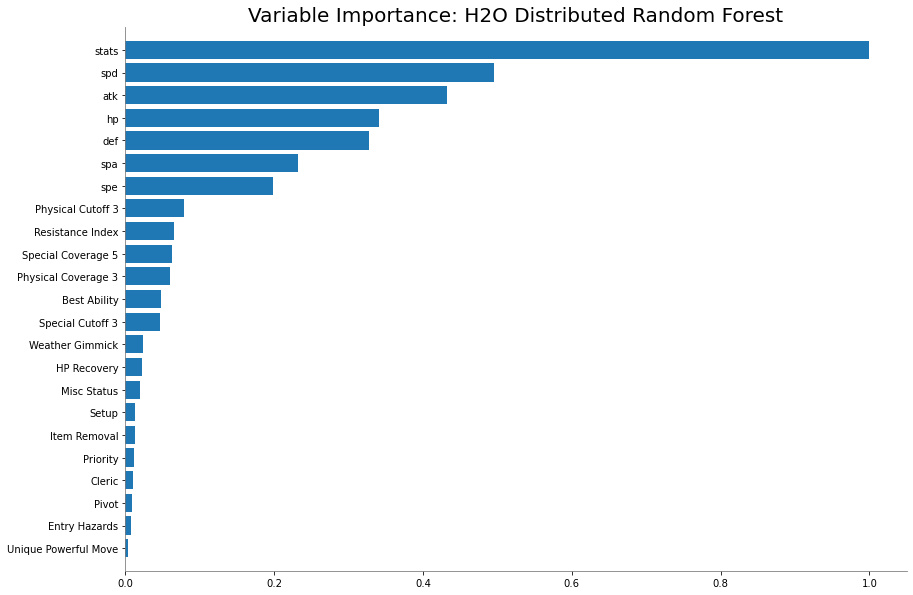

In [47]:
first_stage.varimp_plot(23)

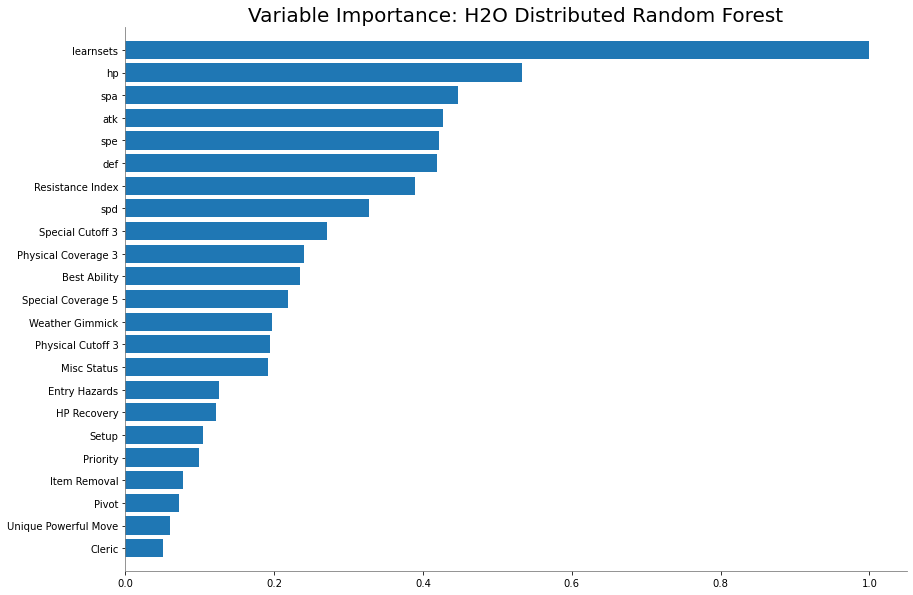

In [48]:
second_stage.varimp_plot(23)

In [49]:
#Setting up the data
X_final = pd.merge(X_gen, cluster_dfs[5]['stats'], on='name')
X_final = pd.merge(X_final, cluster_dfs[15]['learnsets'], on='name')

In [50]:
gen_value_counts = {}

for gen in list(pokemon_data['generation'].unique()):
    generation = X_final.loc[X_final['generation'] == gen, :].copy()
    generation['name'] = generation.index
    cols = generation.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    generation = generation[cols]
    generation_h2 = h2o.H2OFrame(generation)
    generation_h2['Unique Powerful Move'] = generation_h2['Unique Powerful Move'].asfactor()
    generation_h2['stats'] = generation_h2['stats'].asfactor()
    generation_h2['learnsets'] = generation_h2['learnsets'].asfactor()
    
    pred_1 = generation_h2['name']
    pred_1['prediction'] = first_stage.predict(generation_h2.drop(['name', 'learnsets', 'generation']))[0]

    pred_1_mask = pred_1['prediction'] == 'Yes'
    
    pred_2 = generation_h2['name'][pred_1_mask]
    pred_2['prediction'] = second_stage.predict(generation_h2.drop(['name', 'stats', 'generation'])[pred_1_mask, :])[0]

    y_pred = pred_1.as_data_frame().merge(pred_2.as_data_frame(), on='name', how='left')['prediction_y'].fillna(value='ZU')

    gen_value_counts[gen] = y_pred.value_counts()*100 / len(y_pred)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |████████████████████████

In [51]:
gen_value_counts = pd.DataFrame(gen_value_counts)
gen_value_counts

,RB,GS,RS,DP,BW,XY,SM,SS
NU,5.128205,1.785714,2.325581,4.347826,3.846154,1.724138,3.636364,5.357143
OU,5.128205,5.357143,6.976744,5.797101,6.923077,3.448276,8.181818,6.250000
PU,29.914530,33.928571,26.744186,31.884058,26.923077,25.862069,27.272727,31.250000
RU,4.273504,5.357143,3.488372,5.797101,3.076923,10.344828,7.272727,1.785714
UU,3.418803,5.357143,2.325581,5.797101,7.692308,6.896552,2.727273,3.571429
Uber,2.564103,7.142857,3.488372,10.144928,7.692308,5.172414,9.090909,10.714286
ZU,49.572650,41.071429,54.651163,36.231884,43.846154,46.551724,41.818182,41.071429


In [52]:
gen_value_counts.rank(axis=1, ascending=False)

,RB,GS,RS,DP,BW,XY,SM,SS
NU,2.0,7.0,6.0,3.0,4.0,8.0,5.0,1.0
OU,7.0,6.0,2.0,5.0,3.0,8.0,1.0,4.0
PU,4.0,1.0,7.0,2.0,6.0,8.0,5.0,3.0
RU,5.0,4.0,6.0,3.0,7.0,1.0,2.0,8.0
UU,6.0,4.0,8.0,3.0,1.0,2.0,7.0,5.0
Uber,8.0,5.0,7.0,2.0,4.0,6.0,3.0,1.0
ZU,2.0,6.5,1.0,8.0,4.0,3.0,5.0,6.5


Results:
- Generation 1: a higher percentage in lower classes like ZU and NU, and a very low percentage in high classes like Uber and OU, so that makes it among the worst generations competitively. This makes some sense, since its stats and type features are relatively low, but mainly gimmicky and learnset features are high, and those are generally less important (learnset is more useful for locating a pokemon in higher tiers rather than placing them in a higher tier, since it was the clustering used in the 2nd stage).
- Generation 2: this generation is more middle of the pack in most things, though it has a very high concentration of PU (low competitive) pokemon and low concentration of NU (which doesn't mean as much, since it's a small tier to begin with). The stats of this generation are more mixed, with defensive stats being quite good and attacking stats quite poor, so this averaging out could make sense. The high concentration of PU might be explained by the presence of many defensive pokemon and tactics in this generation; such tactics can give a lot of pokemon a place in a low competitive setting since they can soak up the weaker attacks in these tiers, while not having enough ability to proactively affect the game to give these pokemon a chance in higher tiers.
- Generation 3: This one has quite polarized and unusual results, being the absolute highest concentration of ZU (uncompetitive) and high concentrations of OU (one of the highest tiers), and being very low in almost everything else. The quite low stats in this generation would explain the high concentration of ZU, but the high rating of physical learnsets and weather abilities could offer some unique niches in high competitive play (e.g. Pelipper, a pokemon good mainly due to its drizzle ability).
- Generation 4: This generation had very high ratings for most of its features, so it makes sense that it would have a high concentration of Ubers (highest tier) and the lowest concentration of any generation in uncompetitive pokemon (ZU). There is also a strangely high concentration in the PU (low competitive tier), but that's probably due to the highest baseline features in this generation making many pokemon that would be ZU into PU.
- Generation 5: This generation, similar to generation 2, is relatively undistinctive, though slighter higher than average in many tiers. It's especially high in UU (the 3rd highest tier) and especially low in RU (the 4th highest tier), and since those are middling, it's harder to interpret. But overall, this generation is probably the most balanced yet with a high general amount of strong pokemon in each tier without going overboard and being highly concentrated in some areas. It could also be the highly rated miscellaneous and gimmicky features in this generation (even though the stats aren't especially good though also not especially bad) are giving many pokemon niches in a variety of tiers in spite of being unusual in terms of their stats or learnsets, which aren't as highly rated in this generation.
- Generation 6: This is another quite unusual one, with very high concentrations in high-middle tiers like UU and RU, yet very low concentrations in high tiers like OU and Uber and low competitive tiers like NU and PU. It has some similarities with Generation 2 since it has high defensive stats and is lower in other stats. Since this generation also has the highest resistance index feature, this may bolster the defensive stats so that their baseline goes beyond PU (as it was in generation 2) into having a defensive role in the more middle to high tiers. But overall the stats aren't good enough in this generation to have a lot of presence in higher tiers which may require more offensive capabilities (judging by the importance of attack and special attack in feature importances for the 2nd stage model which sorts into higher tiers) or overpowered mechanics (like weather, as we saw in generation 3).
- Generation 7: This overall a quite powerful generation, with high concentration in higher tiers and low concentrations in lower tiers. OU and RU have unusually high concentrations, and UU has unusually low (but this may be happenstance or due to the unusual mechanics in UU, since UU is directly between OU and RU). There are also a lot of Ubers, probably because they released a lot of mythical pokemon in this generation which have high stats (and this has been a pattern in recent generations, which may be leading to some power creep in the higher tiers).
- Generation 8: The high amount of legendary pokemon continues in this generation, with it still reaching number 1 in Ubers in spite of losing its strongest pokemon, Zacian (since it is banned from Ubers). You can also that it has nearly the highest unique powerful move count, along with generation 7, which corresponds to their high concentrations of Ubers. The high concentrations in middling tiers like NU and low concentrations in RU are harder to explain and more happenstance or related to those unique meta games. The stats are average in this generation, so its concentrations are otherwise pretty average.